# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### Comienzo cargando las librerías con las que trabajaré.

In [2]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

In [3]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
dataset = pd.read_json('dataset_es_dev.json', orient = 'records', lines=True)

### Análisis Exploratorio de los datos

In [5]:
#Imprimo las primeras filas del dataset para ver qué contienen. 
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


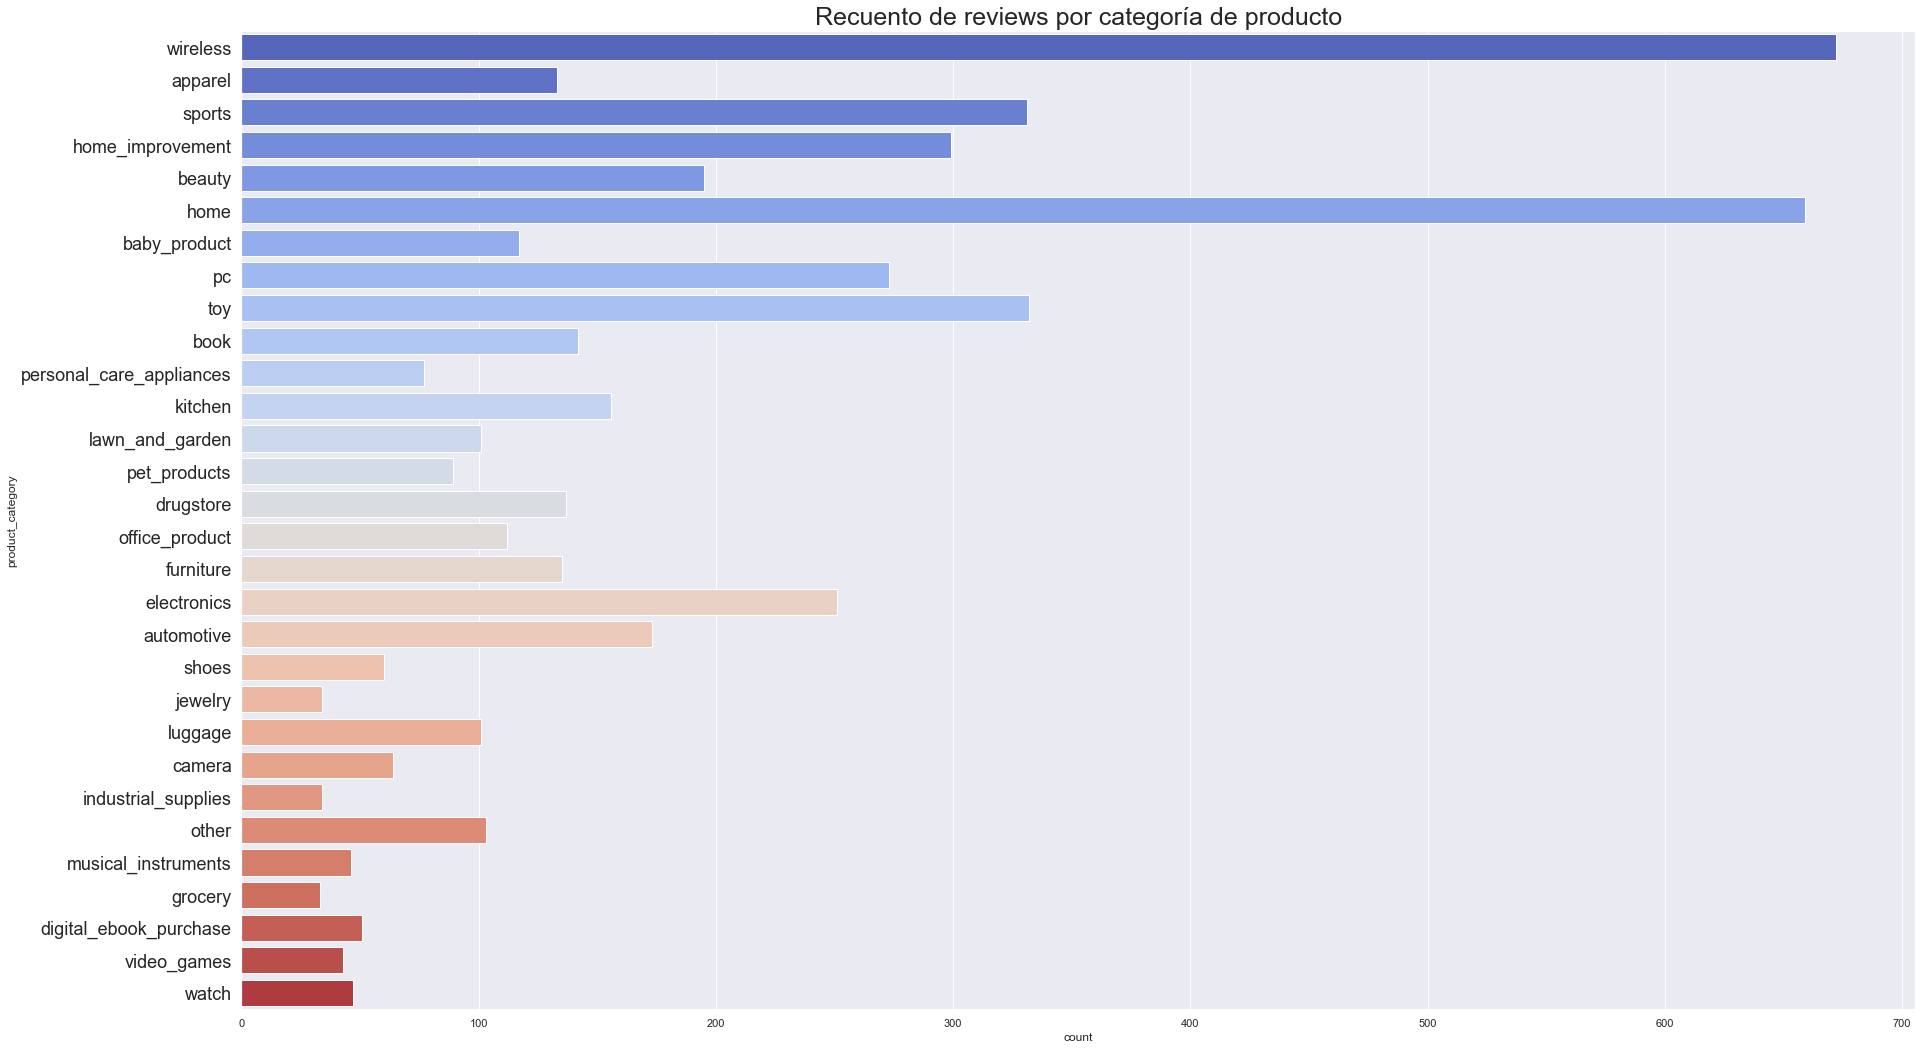

In [6]:
# La mayoria de los productos corresponden a la categoría "Wireless" y "home".
plt.figure(figsize=(30,18))
plot=sns.countplot(data = dataset, y = "product_category", palette="coolwarm")
plot.set_yticklabels(plot.get_ymajorticklabels(), fontsize = 18)
plot.set_title( "Recuento de reviews por categoría de producto" , size = 25 )
plt.show()

In [7]:
dataset.shape

(5000, 8)

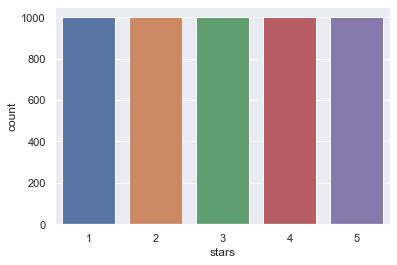

In [8]:
# Relizo un gráfico de recuento para las calificaciones que tiene el dataset. Son 1000 registros para cada estrella.
sns.countplot(data= dataset, x="stars")
plt.show()

Se trata de un dataset balanceado, lo que, a priori, puede ser una ventaja al momento de predecir.

In [9]:
# Miro al azar una review para ver en qué consisten.
index_random = np.random.randint(1,5000)
titular = dataset.review_body.iloc[index_random]
print(index_random, titular)


301 No me ha gustado nada, calidad cero parece que este todo pringado de pegamento y es la silicona, lleva una cinta de doble cara lo pegas y luego lo pones encima y lo he tenido que quitar se queda suelto no pega nada, y para lo que vale es un robo!


In [10]:
print(index_random, dataset.stars.iloc[index_random])


301 1


### Tokenización exploratoria

In [11]:
index_random = np.random.randint(0,high = dataset.shape[0])
review = dataset.iloc[index_random].review_body
print(index_random, review)


2656 Esta mejor la de dolce gusto


In [12]:
review_st= nltk.tokenize.word_tokenize(review)
review_st



['Esta', 'mejor', 'la', 'de', 'dolce', 'gusto']

In [13]:
# Definino las stopwords para el idioma español. Identificarlas permitirá fácilmente descartarlas al momento
# de predecir, ya que estos términos no suelen añadir valor explicativo.
stopwords = nltk.corpus.stopwords.words('spanish')



In [14]:
#imprimo las stopwords
stopwords

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [15]:
review_wt_sin_sw= [word for word in review_st if word not in stopwords]
review_wt_sin_sw

['Esta', 'mejor', 'dolce', 'gusto']

In [16]:
freq = nltk.FreqDist(review_wt_sin_sw)
freq

FreqDist({'Esta': 1, 'mejor': 1, 'dolce': 1, 'gusto': 1})

## Normalización de la información

Antes de comenzar con el trabajo de predicción es necesario procesar el texto que será de input para los modelos, a fin de voverlo apto para la predicción. Importaré las librerias para tokenizar y stemmizar las palabras a analizar. La tokenización permite separar cada término como una entidad única y separada, de manera que sea posible utilizarlo con facilidad al momento de ML. La stemmización consiste en obtener las raíces o reducir las "formas flexivas" (palabras variables) de cada término, a una base o raíz común. 

En este caso, los algoritmos de stemming funcionan cortando el final o el principio de la palabra, teniendo en cuenta una lista de prefijos y sufijos comunes que se pueden encontrar en una palabra flexionada. 

Elegiré esta opción por encima de la lematización, ya que desarrollar un stemmer es mucho más sencillo que construir un lematizador. En este último, se requieren mayores conocimientos lingüísticos para crear los diccionarios que permitan al algoritmo buscar la forma adecuada de la palabra.


  ### Stemmer

In [17]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

#from nltk.stem import SnowballStemmer
#stemmer_spanish = SnowballStemmer('spanish')

Antes de procesar la información, voy a crear una nueva columna en el dataset, donde incluiré el texto de manera conjunta el texto correspondiente a "review body" y el correspondiente a "review_title", de esta manera, le estaré dando mayores features a los modelos para mejorar sus predicciones.

In [18]:
data_concat = dataset.review_title + " " +dataset.review_body
data_concat
dataset["Todojunto"] = data_concat
dataset

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,Todojunto
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No lo he recibido No he recibido el pedido no ...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,Que no aprieta bien en el manillar Tengo que b...
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta No me gusta su olor a viejo y aspe...
...,...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,guadalupe Me ha encantado la cesta. Ha llegado...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,calidad precio Desempeña su función correctamente
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,Excelente Me ha encantado la diadema! Las flor...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,"Genial A mi me gustan mucho las fundas TPU, ya..."


In [19]:
# Recorremos todos los review y le vamos aplicando la tokenización y luega el Stemming a cada uno
review_list=[]
simb=["!",".",",","no","si","...",")","("]
todas_palabras_list=[]
for review in dataset.Todojunto:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    #review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del review
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    #titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords if not palabra in simb]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review = [stemmer.stem(palabra) for palabra in review]
    #review = [palabra for palabra in review]
    # Por ultimo volvemos a unir el titular
    todas_palabras_list.append(review)
    review = " ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)
    


In [20]:
todas_palabras_list[0:10]

[['mala',
  'compra',
  'malisimo',
  'grand',
  'demasiado',
  'aparatoso',
  'mal',
  'protector',
  'pantalla'],
 ['recibido', 'recibido', 'pedido', 'devolución'],
 ['aprieta',
  'bien',
  'manillar',
  'buscar',
  'sistema',
  'funciona',
  'bien',
  'abrazadera',
  'lleva',
  'agarrar',
  'manillar',
  'aprieta',
  'bien',
  'deslizando',
  'linterna',
  'hacia',
  'abajo'],
 ['broca',
  'mantequilla',
  'utilicé',
  'broca',
  'menor',
  'diámetro',
  'doblaron',
  'varia',
  'mantequilla',
  'hacer',
  'mínima',
  'presión',
  'vez',
  'doblada',
  'intentar',
  'enderezarla',
  'parten',
  'exteriorment',
  'amarilla',
  'interior',
  'fundido',
  'gri',
  'peor',
  'compra',
  'hecho',
  'bastant',
  'tiempo'],
 ['gusta', 'gusta', 'olor', 'viejo', 'aspecto', 'malo'],
 ['bola',
  'rota',
  'hola',
  'despué',
  'recog',
  'paquet',
  'llegado',
  'bola',
  'rota'],
 ['part',
  'poder',
  'elegir',
  'color',
  'part',
  'poder',
  'elegir',
  'color',
  'envian',
  'cesto',
  '

In [21]:
flat_list = [item for t in todas_palabras_list for item in t]
flat_list[0:10]

['mala',
 'compra',
 'malisimo',
 'grand',
 'demasiado',
 'aparatoso',
 'mal',
 'protector',
 'pantalla',
 'recibido']

In [22]:
#Imprimo la frecuencia de las palabras
freq = nltk.FreqDist(flat_list)
freq

FreqDist({'bien': 1632, 'calidad': 1102, 'producto': 833, 'buena': 754, 'precio': 721, 'buen': 460, 'funciona': 364, 'bastant': 360, 'perfecto': 336, 'mejor': 314, ...})

In [23]:
review_list[0:5]

['mala compra malisimo grand demasiado aparatoso mal protector pantalla',
 'recibido recibido pedido devolución',
 'aprieta bien manillar buscar sistema funciona bien abrazadera lleva agarrar manillar aprieta bien deslizando linterna hacia abajo',
 'broca mantequilla utilicé broca menor diámetro doblaron varia mantequilla hacer mínima presión vez doblada intentar enderezarla parten exteriorment amarilla interior fundido gri peor compra hecho bastant tiempo',
 'gusta gusta olor viejo aspecto malo']

In [24]:
#añado una columna con las reviews stemmizadas al dataset
dataset["review_stem"] = review_list
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,Todojunto,review_stem
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,guadalupe Me ha encantado la cesta. Ha llegado...,guadalup encantado cesta llegado impecable.tie...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,calidad precio Desempeña su función correctamente,calidad precio desempeña función correctament
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,Excelente Me ha encantado la diadema! Las flor...,excelent encantado diadema flore tal vienen im...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,"Genial A mi me gustan mucho las fundas TPU, ya...",genial gustan funda tpu funda normalment fina ...
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,Buena calidad El artículo ha cumplido con las ...,buena calidad artículo cumplido expectativa de...


In [25]:
#En base a la frecuencia de palabras elaboro un breve dataframe para visualizar los primeros días valores más frecuentes.
df_freq = pd.DataFrame(list(freq.items()), columns = ["Word", "frecuency"])
df_freq.sort_values('frecuency',ascending=False, inplace = True)
df_freq.head(10)

,Word,frecuency
13,bien,1632
84,calidad,1102
93,producto,833
596,buena,754
89,precio,721
1277,buen,460
17,funciona,364
47,bastant,360
1627,perfecto,336
517,mejor,314


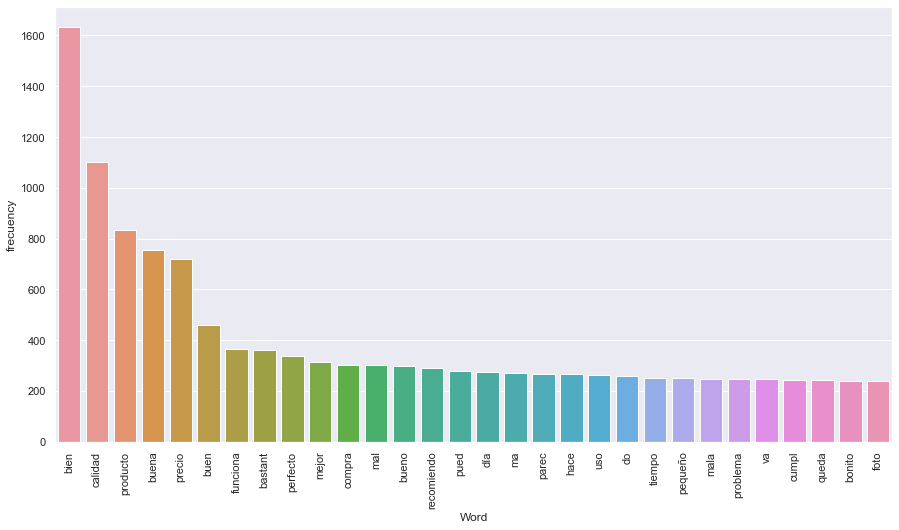

In [26]:
#Grafico las palabras pro frecuencia
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_freq.iloc[:30].Word, y = df_freq.iloc[:30].frecuency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [27]:
from wordcloud import WordCloud
text= " ".join(title for title in dataset.review_stem)
word_cloud = WordCloud(width=5000, height=3000,collocations = False, background_color = 'black').generate(text)

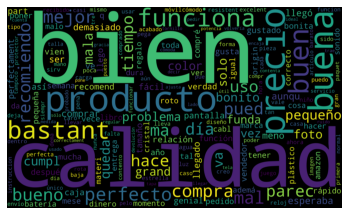

In [28]:
#WordCloud para las palabras Stemmizadas.
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Vectorizacion

Mediante este paso, fundamental antes de avanzar con el modelado, generaré un vector que represente a todas las palabras del corpus a analizar. Esto significa, representar cada instancia (palabra) como un vector con la cantidad de apariciones correspondientes. 

In [29]:
list_review_stem = list(dataset['Todojunto'].values)
Calification = dataset['stars'].values


In [30]:
list_review_stem[1]

'No lo he recibido No he recibido el pedido no la devolución'

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 10000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=10000

# Es decir que cada instancia tendrá 1000 features
cou_vec = CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)


In [32]:
cou_vec

CountVectorizer(max_features=10000)

In [33]:
matriz_reviews = cou_vec.fit_transform(list_review_stem)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 primeras palabras
print("50 primeras palabras: ",all_words[0:50])


50 primeras palabras:  ['05', '10', '100', '1000', '100x100', '1080', '10cm', '10mm', '11', '12', '125', '12m', '12v', '12º', '13', '130', '135', '14', '15', '150', '150w', '150x190', '15h', '15min', '16', '160', '16gb', '17', '18', '180', '180gr', '18kg', '18º', '19', '1978', '1a', '1er', '1h', '1º', '20', '200', '2000', '20000', '2001', '2006', '2007', '200w', '2011', '2017', '2018']


In [34]:
print(all_words)

['05', '10', '100', '1000', '100x100', '1080', '10cm', '10mm', '11', '12', '125', '12m', '12v', '12º', '13', '130', '135', '14', '15', '150', '150w', '150x190', '15h', '15min', '16', '160', '16gb', '17', '18', '180', '180gr', '18kg', '18º', '19', '1978', '1a', '1er', '1h', '1º', '20', '200', '2000', '20000', '2001', '2006', '2007', '200w', '2011', '2017', '2018', '2019', '20ml', '21', '22', '23', '230', '24', '240', '24h', '25', '25cm', '26', '27', '28', '29', '2ds', '2g', '2h', '2horas', '2kg', '2m', '2meses', '2mm', '2s', '2º', '30', '300', '3000', '300mm', '300w', '303', '30l', '30w', '32', '3200', '33', '35', '36', '360', '37', '38', '380', '3900', '3años', '3b', '3d', '3x1', '40', '40e', '41', '43', '44', '45', '48', '49', '4g', '4gb', '4ghz', '4h', '4k', '4x', '50', '500', '5000', '500g', '5400', '5400rpm', '55', '5a', '5c', '5cm', '5ghz', '5l', '5meses', '5t', '5x', '5ª', '60', '64', '64gb', '65', '65cm', '68', '69', '6cm', '6d', '6l', '6mm', '6s', '6x', '70', '70m2', '70mm', '7

In [35]:
type(all_words)

list

## Modelado

In [81]:
#Definición de las variables predictoras y a predecir.
x = matriz_reviews.toarray()
y = Calification
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [82]:
len(Calification)

5000

In [83]:
matriz_reviews.shape

(5000, 10000)

In [84]:
len(ytrain)

4000

In [85]:
xtrain.shape

(4000, 10000)

### Comienzo definiendo un modelo Benchmark

Selecciono un modelo "Naive Bayes". Este modelo me permitirá tener un benchmark de referencia para evaluar el accuracy.

In [89]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc Test :", nb.score(xtest,ytest))
print("acc Train:", nb.score(xtrain,ytrain))

acc Test : 0.322
acc Train: 0.85725


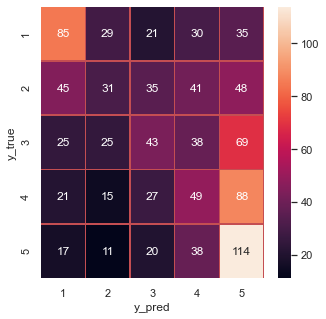

In [87]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

El modelo benchmark muestra bajo desempeño en test. Además, la diferencia elevada entre el accuracy para Train y Test (0.85 vs 0.32) indican que el modelo tiende al overfitting, es decir, que el algoritmo se "aprende de memoria" los datos de entrenamiento y luego tiene dificultades para predecir con datos nuevos. 

## Machine Learning. Implementación de distintos modelos. 

### Random Forest Classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 3500, random_state=42, max_depth=7)
rf.fit(xtrain,ytrain)
print("acc test: ",rf.score(xtest,ytest))
print("acc train: ",rf.score(xtrain,ytrain))

acc test:  0.475
acc train:  0.65625


In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1", "2", "3", "4", "5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return


In [44]:
y_pred=rf.predict(xtest)


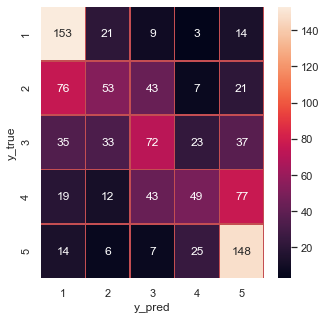

In [45]:
confusion(ytest,y_pred)

La matriz indica que el modelo predice bien los valores extremos (1 y 5) mientras que en los valores intermedios (2 y 4) presenta dificultades. 
Además, el modelo muestra gran diferencia en accuracy entre Train y Test, mostrando indicios de Overfitting, ya que el modelo muestra buen desempeño con los datos de entrenamiento (.65) pero tiene problemas para predecir con nuevos datos (.47). No obsbante, el modelo se desempeña notablemente mejor que el modelo benchmark.

In [47]:
from sklearn.model_selection import learning_curve

In [48]:
train_sizes, train_scores, valid_scores = learning_curve(rf, xtrain, ytrain, 
                                                         train_sizes = np.linspace(0.0001,1,10),
                                                         scoring = 'accuracy', cv=5)

### Grafico la curva de aprendizaje para Random Forest Classifier.

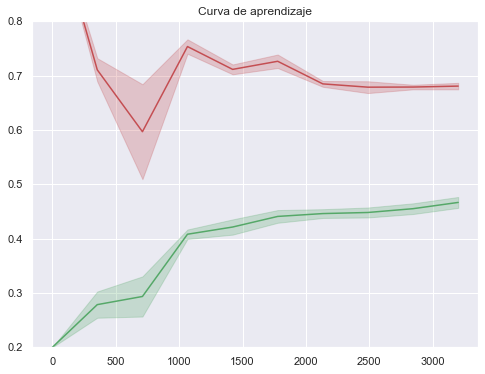

In [91]:
plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")
plt.title("Curva de aprendizaje")
plt.ylim(0.2,0.8)
plt.show()

### Random Forest Regressor

In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import sklearn.metrics as metrics

In [51]:
clf_tree = RandomForestRegressor(n_estimators=3500, max_features=5000,n_jobs=-1, random_state = 0, criterion="mse")
clf_tree.fit(xtrain,ytrain)

RandomForestRegressor(max_features=5000, n_estimators=3500, n_jobs=-1,
                      random_state=0)

In [52]:
y_train_pred_clf = clf_tree.predict(xtrain)
y_test_pred_clf = clf_tree.predict(xtest)

In [53]:
print('RMSE para Train', np.sqrt(metrics.mean_squared_error(ytrain, y_train_pred_clf)))
print('RMSE para Test', np.sqrt(metrics.mean_squared_error(ytest, y_test_pred_clf)))

RMSE para Train 0.3811069523942922
RMSE para Test 1.0617131717278487


In [54]:
comparacion_tree_reg = pd.DataFrame({'Real Values':ytest, 'Predicted Values':y_test_pred_clf})
comparacion_tree_reg

,Real Values,Predicted Values
0,2,1.233714
1,4,2.314571
2,1,1.659143
3,3,3.010000
4,3,3.099429
...,...,...
995,2,3.135714
996,1,2.324286
997,1,1.748857
998,3,2.992000


En general, el Random Forest Regressor muestra un desempeño bueno en train pero un mal desempeño en los datos de testeo (0.38 vs 1.06). Al igual que con el Random Forest Classifier, el Random Forest Regressor tiende al overfitting.

### SVM

Implementaré un modelo de Support Vector Machine para evaluar posibles mejoras en la predicción, con respecto a los otros modelos desarrollados.

In [55]:
from sklearn.svm import SVC
model = SVC(gamma= 0.1)
model.fit(xtrain,ytrain)

SVC(gamma=0.1)

In [56]:
print("acc: ", model.score(xtest,ytest))

acc:  0.397


In [57]:
print("acc: ", model.score(xtrain,ytrain))

acc:  0.97825


La notable diferencia de desempeño entre los datos para Test y para Train (0.397 de accuraccy vs 0.987) indican el serio overffiting del modelo, es decir, que los datos no están pudiendo realizar generalizaciones cuando se encuentran con datos nuevos. Esto indica que el modelo debe optimizarse, o explorarse otras alternativas.

In [58]:
SVM_pred=model.predict(xtest)

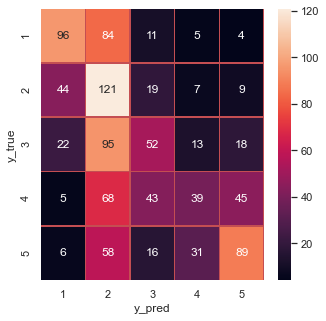

In [59]:
# Creo una matriz de confusión para evaluar con mayor detalle el desempeño del SVM.
confusion(ytest,SVM_pred)

En general, la matriz permite indicar que el modelo tiene especiales dificultades para clasificar valores intermedios (3 y 4, particularmente) además que suele tener problemas para distinguir entre valores cercanos (por ejemplo, asigna como valor "2" a registros que en realidad son "1" o como  "2" a valores que en realidad son "3". 

In [60]:
comparacion_SVM = pd.DataFrame({'Real Values':ytest, 'Predicted Values':SVM_pred})
comparacion_SVM

,Real Values,Predicted Values
0,2,1
1,4,2
2,1,2
3,3,2
4,3,3
...,...,...
995,2,3
996,1,2
997,1,1
998,3,1


#### GridSearch para SVM

Aplicaré esta técnica que permite evaluar y seleccionar de forma sistemática los parámetros del modelo. De esta manera, evaluaré el rendimiento del SVM en función de los parámetros mediante validación cruzada, a fin de intentar mejorar el desempeño. 

In [63]:
# Creo el diccionario con los parámetros a considerar
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [65]:
# Instancio la funcion GridSearch para el modelo SVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(xtrain,ytrain)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   3.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   3.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   3.4s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   3.4s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   3.6s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   3.4s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   3.9s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   3.9s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   4.3s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   3.8s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   3.8s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   4.3s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   4.5s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   4.3s
[CV] END ...................

[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   4.8s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   4.8s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   2.1s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   2.3s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   2.5s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   2.3s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   2.2s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   4.4s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   4.6s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   4.8s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   4.4s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   4.3s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [66]:
# Salida con los mejores estimadores para este modelo
print(grid.best_estimator_)

SVC(C=10, gamma=0.001)


In [67]:
# Realizo predicciones de acuerdo en base a los datos de X para test de acuerrdo a los parámetros identificados
#por GridSearch.
from sklearn.metrics import classification_report
grid_predictions = grid.predict(xtest)



In [93]:
print("acc test: ", grid.score(xtest,ytest))
print("acc train: ", grid.score(xtrain,ytrain))

acc test:  0.462
acc train:  0.6525


In [69]:
# Imprimo un classification report para evaluar de forma completa las predicciones hechas con Gridsearch
print(classification_report(ytest,grid_predictions))

              precision    recall  f1-score   support

           1       0.57      0.67      0.61       200
           2       0.38      0.35      0.36       200
           3       0.37      0.34      0.35       200
           4       0.45      0.23      0.31       200
           5       0.49      0.72      0.58       200

    accuracy                           0.46      1000
   macro avg       0.45      0.46      0.44      1000
weighted avg       0.45      0.46      0.44      1000



En general, luego de aplicar los parámetros identificados por GridSearch el desempeño de SVM mejora considerablemente (pasa de 0.397 a 0.462 actualmente) y descendiendo considerablemente la diferencia entre el desempeño entre train y test (indicando que el overfitting es menor). De todas maneras, no dejan de ser diferencias notables y la accuracy es aún baja, ya que el modelo no es capaz de predecir correctamente al menos ni la mitad de los valores que se le presentan.

In [70]:
# Matriz de Confusión para las predicciones hechas con los parametros de Gridsearch
print(confusion_matrix(ytest,grid_predictions))

[[133  37  17   3  10]
 [ 59  70  42   7  22]
 [ 29  42  67  24  38]
 [  7  21  42  47  83]
 [  6  15  11  23 145]]


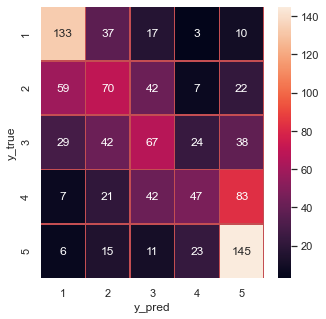

In [71]:
#Grafico las Matriz de Confusión para mejor visualización. 
confusion(ytest,grid_predictions)

La matriz de confusión permite apreciar mejoras respecto al primer modelo de SVM desarrollado, con gran precisión para predecir valores extremos (1 y 5) y algunas dificultades con los valores intermedios, especialmente 3 y 4. 

### Regresión Lineal Simple

Probaré también con una regresión lineal para evaluar si resulta un modelo apropiado para este caso

In [72]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [73]:
reg.fit(xtrain, ytrain)

LinearRegression()

In [74]:
ytrain_pred =reg.predict(xtrain)
ytest_pred = reg.predict(xtest)


In [75]:
from sklearn.metrics import mean_squared_error
rmse_train = np.sqrt(mean_squared_error(ytrain, ytrain_pred))
rmse_test = np.sqrt(mean_squared_error(ytest, ytest_pred))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 0.0005812125136230803
Raíz del error cuadrático medio en Test: 9.936089712158822


El modelo de RLS muestra los mismos inconvenientes que han demostrado los otros modelos implementados. Una seria dificultad del modelo para desempeñarse de manera satisfactoria con los datos de test, indicando también aquí un serio overfitting. 

In [76]:
comparacion_lr = pd.DataFrame({'Real Values':ytest, 'Predicted Values':ytest_pred})
comparacion_lr

,Real Values,Predicted Values
0,2,3.178111
1,4,7.391595
2,1,0.604430
3,3,8.582116
4,3,2.508703
...,...,...
995,2,17.081931
996,1,7.813666
997,1,1.190371
998,3,11.075766


C:\Users\juanl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\juanl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


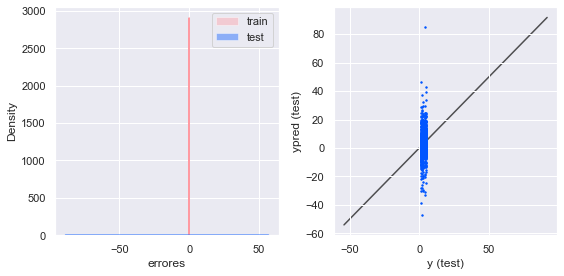

In [77]:
plt.figure(figsize = (8,4), clear=True,)

plt.subplot(1,2,1)
sns.distplot(ytrain - ytrain_pred, bins = 40, label = 'train',color="#FF9AA2")
sns.distplot(ytest - ytest_pred, bins = 40, label = 'test', color="#0055FF")
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(ytest,ytest_pred, s =2, c="#0055FF")
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  
np.max([ax.get_xlim(), ax.get_ylim()]),  
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('ypred (test)')
    
plt.tight_layout()
plt.show()

### Conclusión final

El mejor desempeño ha sido con los parámetros sugeridos por GridSearch para SVM, y el Random Forest Classifier ha tenido un comportamiento similar. Todos los modelos implementados muestran serios problemas para predecir con los datos de validación, indicando overfitting. Esto puede deberse a que se necesitan más "features" en la variable predictora para robustecer a los algorítimos y mejorar el desempeño.

Como otras alternativas para probar en este caso, iría por una estrategia como la que desarrollan en este artículo: https://towardsdatascience.com/a-complete-sentiment-analysis-algorithm-in-python-with-amazon-product-review-data-step-by-step-2680d2e2c23b 

Asignando una eqieta de "good review" y "bad review" de acuerdo al número de estrellas asignadas para 1 y 2 "bad review" y para 4 y 5 "good reviews". Descartarían los valores intermedios (3) porque son difíciles de catalogar para el algortimo. Luego, en base al tipo de review obtenido y las palabras utilizadas en cada una de ellas, entrenaría un algoritmo de clasificación y compararía desempeño.